# 04 bis - Clustering with BRUTAL approach

In [54]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import os
import matplotlib.animation as animation

from models.BRUTAL_X_RCC import XRCC#, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
from IPython.display import display

The BRUTAL approach involves providing a set of breakpoint dates to be used in the computation of the loss. The number of possible combinations of breakpoints, given a set of dates and a number of seasons, can be calculated using the binomial coefficient:

$$\binom{n}{k} = \frac{n!}{k!(n-k)!}$$

where:

- $n$ is the number of dates, and
- $k$ is the number of seasons.

In [55]:
# -- FREE PARAMETERS
n_seasons   = 4
n_days = list(np.arange(0,365,40))

overwrite_results = False

In [56]:
# DA togliere solo per salvare il file
n_iters = 10

# Geopackages with boundaries
country_boundary_file   = '../data/preprocessed/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/preprocessed/external/GADM41_WORLD_clip.gpkg' 
hkkh_boundary_file      = '../data/preprocessed/external/HKKH.gpkg'

# Path for results
results_path_file   = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.nc'
results_path_image  = f'../data/results/images/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.png'

if os.path.exists(results_path_file) and overwrite_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not overwrite_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file)
hkkh_boundary       = gpd.read_file(hkkh_boundary_file)

In [57]:
if not os.path.exists(results_path_file) or overwrite_results:

    dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load()
    dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load()
    dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load()
    dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load()

    dataset_tp['time'] = dataset_t2m['time']
    dataset_u100['time'] = dataset_t2m['time']
    dataset_v100['time'] = dataset_t2m['time']

    datasets = [dataset_tp, dataset_t2m, dataset_u100, dataset_v100] 

    clustering_params = {
        'n_days' : n_days,
        'n_seas': n_seasons,
    }

    breakpoints, error_history_da, silhouette_scores_da = XRCC(datasets, **clustering_params)

else:
    result = xr.open_dataset(results_path_file).__xarray_dataarray_variable__

210it [00:00, 704.11it/s]
210it [00:00, 702.51it/s]
210it [00:00, 714.81it/s]
210it [00:00, 680.80it/s]
210it [00:00, 709.20it/s]
210it [00:00, 718.13it/s]
210it [00:00, 720.81it/s]
210it [00:00, 711.45it/s]
210it [00:00, 716.22it/s]
210it [00:00, 710.48it/s]
210it [00:00, 715.05it/s]
210it [00:00, 720.06it/s]
210it [00:00, 716.58it/s]
210it [00:00, 716.08it/s]
210it [00:00, 717.22it/s]
210it [00:00, 714.51it/s]
210it [00:00, 711.77it/s]
210it [00:00, 721.19it/s]
210it [00:00, 717.24it/s]
210it [00:00, 722.86it/s]
210it [00:00, 700.19it/s]
210it [00:00, 719.53it/s]
210it [00:00, 715.04it/s]
210it [00:00, 715.75it/s]
210it [00:00, 637.91it/s]
210it [00:00, 508.77it/s]
210it [00:00, 283.43it/s]
210it [00:00, 380.52it/s]
210it [00:00, 695.29it/s]
210it [00:00, 715.02it/s]
210it [00:00, 719.24it/s]
210it [00:00, 713.29it/s]
210it [00:00, 720.64it/s]
210it [00:00, 608.83it/s]
210it [00:00, 510.03it/s]
210it [00:00, 510.31it/s]
210it [00:00, 455.72it/s]
210it [00:00, 483.90it/s]
210it [00:00

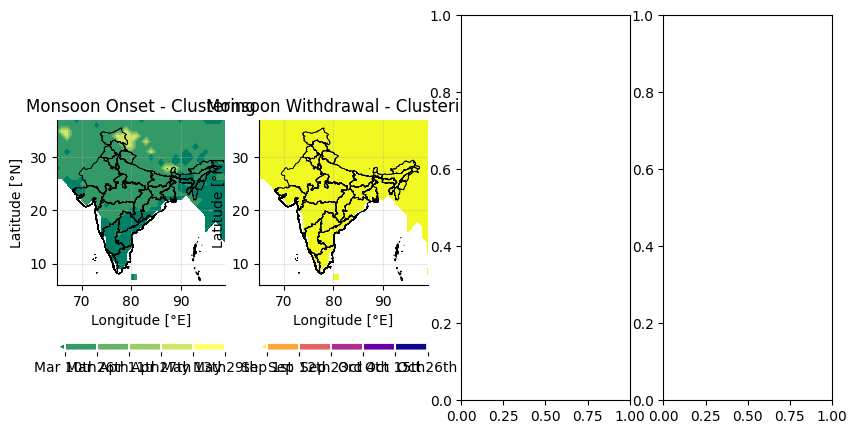

In [58]:
result_plot = breakpoints

plot_seasons_bk_results( result_plot, figsize=(10,5), cmaps=['summer', 'plasma_r'],
                         lims=[[70,150],[245,300]], titles=['Monsoon Onset - Clustering', 'Monsoon Withdrawal - Clustering'],
                         country_boundary=country_boundary, world_boundary=country_boundary)

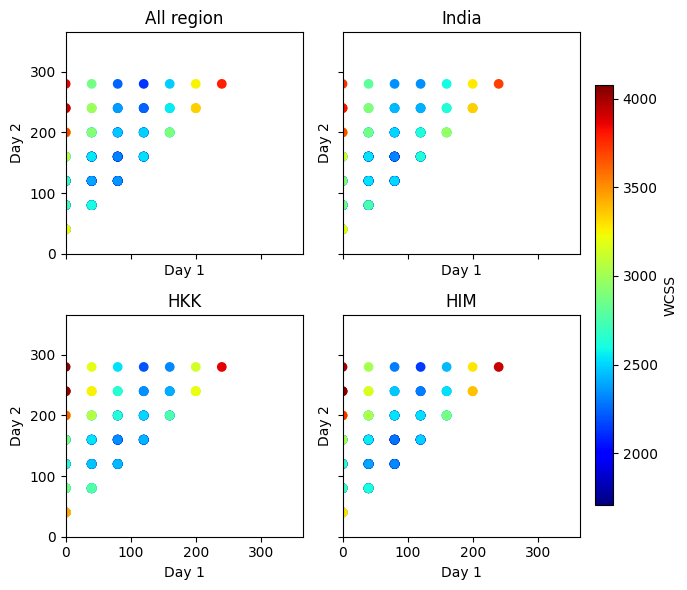

In [59]:
from itertools import combinations

x = np.array(list(combinations(n_days, n_seasons))).squeeze()[:,0]
y = np.array(list(combinations(n_days, n_seasons))).squeeze()[:,1]


# Load country boundary data
error_history_da_clip = error_history_da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
error_history_da_clip.rio.write_crs("epsg:4326", inplace=True)


error_history_da_clip_IND = error_history_da_clip.rio.clip(country_boundary.geometry.apply(mapping), country_boundary.crs, drop=True)
error_history_da_clip_HKK = error_history_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='hkk'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='hkk'].crs, drop=True)
error_history_da_clip_HIM = error_history_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='him'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='him'].crs, drop=True)

z_all = error_history_da_clip.mean(['lat', 'lon']).values
z_IND = error_history_da_clip_IND.mean(['lat', 'lon']).values
z_HKK = error_history_da_clip_HKK.mean(['lat', 'lon']).values
z_HIM = error_history_da_clip_HIM.mean(['lat', 'lon']).values


# Trova i limiti comuni per la colorbar
vmin = min(z_all.min(), z_IND.min(), z_HKK.min(), z_HIM.min())
vmax = max(z_all.max(), z_IND.max(), z_HKK.max(), z_HIM.max())

# Crea i subplot
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)

# Scatter plot per ciascuna regione
sc1 = ax[0][0].scatter(x, y, c=z_all, cmap='jet', vmin=vmin, vmax=vmax)
ax[0][0].set_title('All region')
ax[0][0].set_xlabel('Day 1')
ax[0][0].set_ylabel('Day 2')

sc2 = ax[0][1].scatter(x, y, c=z_IND, cmap='jet', vmin=vmin, vmax=vmax)
ax[0][1].set_title('India')
ax[0][1].set_xlabel('Day 1')
ax[0][1].set_ylabel('Day 2')

sc3 = ax[1][0].scatter(x, y, c=z_HKK, cmap='jet', vmin=vmin, vmax=vmax)
ax[1][0].set_title('HKK')
ax[1][0].set_xlabel('Day 1')
ax[1][0].set_ylabel('Day 2')

sc4 = ax[1][1].scatter(x, y, c=z_HIM, cmap='jet', vmin=vmin, vmax=vmax)
ax[1][1].set_title('HIM')
ax[1][1].set_xlabel('Day 1')
ax[1][1].set_ylabel('Day 2')

# Imposta i limiti dell'asse x e y
ax[0][0].set_xlim([0, 365])
ax[0][0].set_ylim([0, 365])


# Crea una colorbar comune a destra della figura
fig.subplots_adjust(right=0.85)  # Riduci la larghezza della figura per fare spazio alla colorbar
cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])  # Posizione: [left, bottom, width, height]
cbar = fig.colorbar(sc1, cax=cbar_ax)
cbar.set_label('WCSS')

plt.tight_layout()
plt.show()


In [68]:
indices

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

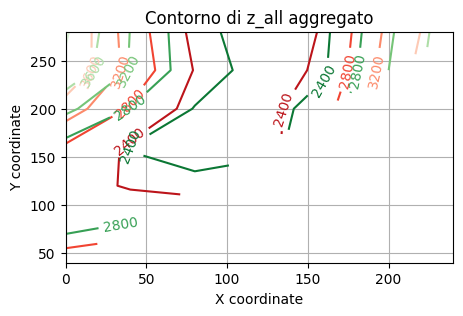

In [60]:
# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z_HIM = np.empty(X.shape)
Z_HKK = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z_HIM[j, i] = np.mean(z_HIM[indices]) if np.any(indices) else np.nan  # Media dei valori corrispondenti
        Z_HKK[j, i] = np.mean(z_HKK[indices]) if np.any(indices) else np.nan

# Creare il grafico a contorni riempiti
plt.figure(figsize=(5, 3))
contour_him = plt.contour(X, Y, Z_HIM, levels=5, cmap='Reds_r')
contour_hkk = plt.contour(X, Y, Z_HKK, levels=5, cmap='Greens_r')

ax = plt.gca()
ax.clabel(contour_him, inline=True, fontsize=10)
ax.clabel(contour_hkk, inline=True, fontsize=10)
#plt.colorbar(contour)
plt.title('Contorno di z_all aggregato')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid()
plt.show()

In [61]:
# # Load country boundary data
# silhouette_scores_da_clip = silhouette_scores_da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
# silhouette_scores_da_clip.rio.write_crs("epsg:4326", inplace=True)


# silhouette_scores_da_clip_IND = silhouette_scores_da_clip.rio.clip(country_boundary.geometry.apply(mapping), country_boundary.crs, drop=True)
# silhouette_scores_da_clip_HKK = silhouette_scores_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='hkk'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='hkk'].crs, drop=True)
# silhouette_scores_da_clip_HIM = silhouette_scores_da_clip.rio.clip(hkkh_boundary[hkkh_boundary.short_name=='him'].geometry.apply(mapping), hkkh_boundary[hkkh_boundary.short_name=='him'].crs, drop=True)

# z_all = silhouette_scores_da_clip.mean(['lat', 'lon']).values
# z_IND = silhouette_scores_da_clip_IND.mean(['lat', 'lon']).values
# z_HKK = silhouette_scores_da_clip_HKK.mean(['lat', 'lon']).values
# z_HIM = silhouette_scores_da_clip_HIM.mean(['lat', 'lon']).values


# fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
# ax[0][0].scatter(x, y, c=z_all, cmap='jet')
# ax[0][0].set_title('All region')
# ax[0][0].set_xlabel('Day 1')
# ax[0][0].set_ylabel('Day 2')

# ax[0][1].scatter(x, y, c=z_IND, cmap='jet')
# ax[0][1].set_title('India')
# ax[0][1].set_xlabel('Day 1')
# ax[0][1].set_ylabel('Day 2')

# ax[1][0].scatter(x, y, c=z_HKK, cmap='jet')
# ax[1][0].set_title('HKK')
# ax[1][0].set_xlabel('Day 1')
# ax[1][0].set_ylabel('Day 2')

# ax[1][1].scatter(x, y, c=z_HIM, cmap='jet')
# ax[1][1].set_title('HIM')
# ax[1][1].set_xlabel('Day 1')
# ax[1][1].set_ylabel('Day 2')

# plt.tight_layout()


In [62]:
# (silhouette_scores_da.isel(iter = -1) - silhouette_scores_da.isel(iter = 0)).plot(vmin=0, vmax=0.1, extend='max', cmap='jet')

In [63]:
# a = silhouette_scores_da.mean(['lat','lon'])#.plot(hue='lon', add_legend=False)

# # sort a by value
# a = a.sortby(a).plot(hue='lon', add_legend=False)
# a

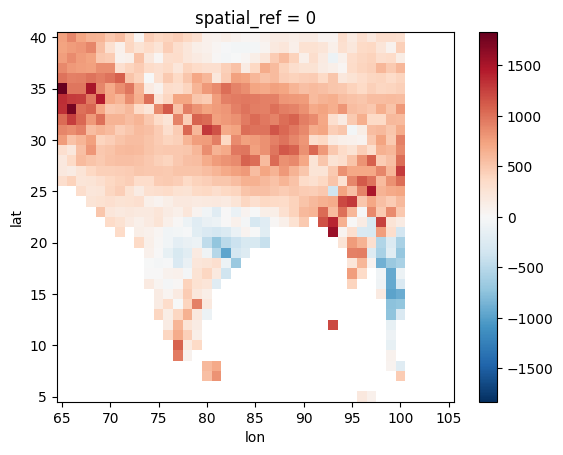

In [64]:
# Sort error_list_da bu value on lon,lat dims
# error_list_da = error_list_da.sortby(error_list_da).plot(hue='lon', add_legend=False)

(error_history_da.isel(iter = -1) - error_history_da.isel(iter = 0)).plot()

In [65]:
# Load country boundary data
# mask_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')
# mask_boundary = mask_boundary[mask_boundary["GID_0"].isin(['IND','NPL','BGD'])]

# result_plot = result.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
# result_plot.rio.write_crs("epsg:4326", inplace=True)
# result_plot = result_plot.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)



# plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

In [66]:
# if not os.path.exists(results_path_file) or overwrite_results:
    
#     result.attrs=dict(
#             Description="Dataset with seasonal onset dates obtained with Radially Constrained Clustering",
#             Parameters=(

#                 f"Number of seasons: {n_seasons}",
#                 f"Number of iterations: {n_iters}",
#                 f"Learning rate: {learning_rate}",
#                 f"Minimum length of seasons: {min_len}",
#                 f"Clustering mode: {mode}",
#                 f"Initializtion dates: {[day_of_year_to_date(x) for x in starting_bp]}",
        
#             )
#         )

#     result.to_netcdf(results_path_file)